#### Code initialisation

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import mapping
import glob

from my_functions_idealisedprofiles_scaled import *

### Read in spatial boundaries of admin zones and filter out Kippax and Garforth
An official shapefile for Garforth itself couldn't be found, so created this boundary in QGIS.  
In QGIS select Layer -> Create layer -> new shapefile layer.  
Press the three dots beside filename to select location to save to.   
Select UTF-8 File encoding and type as Polygon.  
Right click layer, and select 'toggle editing' and then select 'Add Poylgon feature' from toolbar at the top  

In [2]:
all_boundaries = gpd.read_file("../../../../FloodModelling/KippaxBoundary/Parishes/Parishes_December_2016_FCB_in_England_and_Wales.shp")
kippax_boundary = all_boundaries[all_boundaries['par16nm'] == 'Kippax']
garforth_boundary = gpd.read_file("../../../../FloodModelling/GarforthBoundary/Garforth_edited.shp")

### Trim landcover data

In [3]:
# Read in the data
landcover, out_meta = prepare_rainfall_scenario_raster("../../../../FloodModelling/LandCoverData/LandCover_clipped.tif", True)
# Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod =  np.where(landcover==1, 10, landcover)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [1,2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)

### Define list of methods

In [5]:
methods =[ '6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']

### Loop through each method and get all files in its subfolder, and cut them to the extent of the region

In [6]:
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    # Trim land cover data
    raster = rxr.open_rasterio("../../../../FloodModelling/LandCoverData/LandCover_clipped.tif", masked=True).squeeze()
    raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
    if not os.path.exists("../../../../FloodModelling/LandCoverData/{}/".format(region_name)):
        os.mkdir("../../../../FloodModelling/LandCoverData/{}/".format(region_name))
    raster_clipped.rio.to_raster("../../../../FloodModelling/LandCoverData/{}/LandCover_clipped.tif".format(region_name))   
    
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for file in files:
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    

### Check one of the outcomes

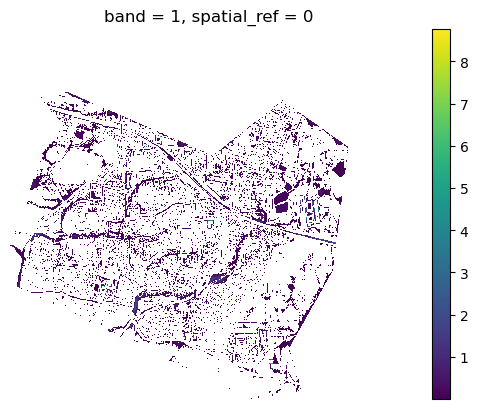

In [20]:
f, ax = plt.subplots()
raster_clipped.plot.imshow()
ax.set_axis_off()
plt.show()

### Check with folium plot

In [23]:
# Set up figure
f = folium.Figure(width=800, height=700)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=13).add_to(f)
folium.TileLayer(
    opacity=1,
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Add to map
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))

region_boundary_feature_group = FeatureGroup(name='Catchment boundary')
region_boundary_feature_group.add_child(folium.GeoJson(data=swillington_boundary["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Red': { "fillColor": '#00000000',"color": 'Red',}))

garforth_feature_group = FeatureGroup(name='Catchment boundary')
garforth_feature_group.add_child(folium.GeoJson(data=garforth_boundary["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Blue': { "fillColor": '#00000000',"color": 'Blue',}))


# Add layer control button
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(region_boundary_feature_group)
mapa.add_child(garforth_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)    